In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("cleaned_data.csv")

In [3]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

In [4]:
df.index = df["AppointmentDay"]

In [5]:
df = df.drop("AppointmentDay", axis=1)

In [6]:
df.columns

Index(['Gender', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'MinutesDiff', 'ScheduledSameDay', 'AppointmentDayofWeek',
       'ScheduledDayofWeek', 'ScheduledHour', 'AppointmentMonth',
       'AppointmentsCount', 'NotShowedCount', 'ProportionNotShowed',
       'FirstAppointment'],
      dtype='object')

### Model evaluation design

Appointments are recorded along a time frame. In addition, some variables have been made taking into consideration the historical activity of the patient. 
In this sense, traditional cross-validation wouldn't be the best option to evaluate the performance of the model, because one could be using information from the "future" to predict the past, for example, one could train with information of the patient A in the date 2016-06-06 and predicting an appointment patient A made for the 2016-05-10.
This is when it comes into consideration Time Series Cross Validation.
sklearn.model_evaluation.TimeSeriesSplit is used to generate test sets that have more recent information than the train sets. 
Considering this the evaluation arquitecture is as follow:
- First of all, we make a train test split, train will be used to select the best model and test to have an accurate estimation of its performance.
- Secondly, in train we will perform multiple runs of models using RandomizedSearchCV to select the best hyperparameters. This is be evaluated with a time series cross validation schema.
- Finally, the best model is trained using the whole train set and predicting in test.

In [7]:
df.index = pd.to_datetime(df.index)

In [8]:
test = df["2016-06-06":"2016-06-08"].copy()

In [9]:
test.index.value_counts()

2016-06-06    4692
2016-06-08    4479
2016-06-07    4416
Name: AppointmentDay, dtype: int64

In [10]:
y_test = test["No-show"]
X_test = test.drop(["No-show"], axis=1)

In [11]:
train = df["2016-04-29":"2016-06-05"].copy()
y_train = train["No-show"]
X_train = train.drop(["No-show"], axis=1)

In [12]:
cv = TimeSeriesSplit()
my_cv = TimeSeriesSplit(n_splits=2).split(X_train)


/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:778: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


### Pipeline design

Different approaches will be evaluated. To have a clean code a pipeline of transformations is proposed.
This pipeline will:

    1- Neighboorhoods pipeline: Take Neighbourhood and make dummy variables from it. A hyperparameter will be to choose whether to take the top 10 (regarding the odds), top 20, top 30 or all the neighbourhoods
    2- Interactions pipeline: this pipeline will make interactions between many dummy variables. These are 'Gender', 'Scholarship', 'Hipertension','Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'ScheduledSameDay'
    3- Cuadratic pipeline: this pipeline make a cuadratic relationship between variables
    4-Selection pipeline: this pipeline selects variables without transformation

After all this transformation, there will be the following steps:

    5- Step to decide whether to do PCA or not
    6- Step to decide whether to do over sampling using SMOTE, under sampling or nothing
    7- Step for automatic variable selection
    8- Model to train

In [13]:
from sklearn.pipeline import make_union, FeatureUnion
from imblearn.pipeline import make_pipeline, Pipeline

In [14]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, PolynomialFeatures

#### Neighboorhoods pipeline

In [15]:
dict_to_replace = {i:j for i,j in zip(list(df["Neighbourhood"].unique()), [i for i in range(81)])}

In [16]:
X_train["Neighbourhood"] = X_train["Neighbourhood"].replace(dict_to_replace)

In [17]:
X_test["Neighbourhood"] = X_test["Neighbourhood"].replace(dict_to_replace)

In [18]:
df["Neighbourhood"] = df["Neighbourhood"].replace(dict_to_replace)

In [19]:
neighbourhood_ctab = pd.crosstab(df["Neighbourhood"], df["No-show"], normalize=True)
neighbourhood_odds = neighbourhood_ctab[1]/neighbourhood_ctab[0] # Odds
neigh_top10 = neighbourhood_odds.sort_values(ascending=False).index.values[1:11]
neigh_top10.sort()
neigh_top20 = neighbourhood_odds.sort_values(ascending=False).index.values[1:21]
neigh_top20.sort()
neigh_top30 = neighbourhood_odds.sort_values(ascending=False).index.values[1:31]
neigh_top30.sort()

In [20]:
def select_column_1(X, column_position = [2]):
    return X.iloc[:,column_position]

In [21]:
neigh_pipeline = Pipeline([("select",FunctionTransformer(select_column_1, validate = False)) , ("encoder",OneHotEncoder(categories=[neigh_top10],handle_unknown="ignore", sparse=False))])

#### Interactions pipeline

In [22]:
pf = PolynomialFeatures(interaction_only=True)

In [23]:
def select_column_2(X, column_position = [0, 3,4,5,6,7,8,10]):
    return X.iloc[:,column_position]

In [24]:
int_pipeline = make_pipeline(FunctionTransformer(select_column_2, validate = False), pf)

#### Cuadratic pipeline

In [25]:
pf_2 = PolynomialFeatures()

In [26]:
def select_column_3(X, column_position = [1,16]):
    return X.iloc[:,column_position]

In [27]:
cuad_pipeline = make_pipeline(FunctionTransformer(select_column_3, validate = False), pf_2)

#### Selection pipeline

In [28]:
def select_column_4(X, column_position = [9,11,12,13,14,15,17,18]):
    return X.iloc[:,column_position]

In [29]:
sel_pipeline = make_pipeline(FunctionTransformer(select_column_4, validate = False))

#### Union of Feature Engineering pipelines

In [30]:
fe_union = FeatureUnion([("neigh_pipeline",neigh_pipeline), ("int_pipeline",int_pipeline),
             ("cuad_pipeline",cuad_pipeline),("sel_pipeline",sel_pipeline)])

#### Models pipeline

In [31]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [32]:
f_selection_step = SelectPercentile(f_classif)
resampling_step = SMOTE()
pca = PCA()
ss = StandardScaler()

In [33]:
from sklearn.metrics import roc_auc_score

## Models evaluation
The following models are evaluated:

- KNN
- SVM
- NaiveBayes
- Logistic Regression
- Random Forest
- LightGBM
- CatBoost


In [34]:
from sklearn.model_selection import RandomizedSearchCV

### KNN

In [34]:
from sklearn.neighbors import KNeighborsClassifier

In [46]:
from scikitplot.metrics import plot_roc
import matplotlib.pyplot as plt
% matplotlib inline

In [36]:
knn = KNeighborsClassifier()

In [37]:
pipeline = make_pipeline(fe_union, ss, pca, resampling_step, f_selection_step,knn)

In [38]:
params = {"featureunion__neigh_pipeline__encoder":[OneHotEncoder(categories=[neigh_top10],sparse = False,handle_unknown="ignore"),
                                                     OneHotEncoder(categories=[neigh_top20],sparse = False,handle_unknown="ignore"),
                                                     OneHotEncoder(categories=[neigh_top30],sparse = False,handle_unknown="ignore"),
                                                  OneHotEncoder(sparse = False,handle_unknown="ignore")], 
          "pca":[None, PCA()],
         "smote": [None,RandomUnderSampler(), SMOTE()], 
          "selectpercentile__percentile":[80,70,50,30],
         "kneighborsclassifier__n_neighbors":[5,8,12,15]}

In [39]:
my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

In [40]:
rs = RandomizedSearchCV(estimator = pipeline, param_distributions=params,cv=my_cv, n_jobs=3, n_iter=20, scoring="roc_auc")

In [41]:
rs.fit(X_train, y_train)

/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [20 56 57] are constant.
  UserWarning)
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fd2de8ac620>,
          error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=None,
       transformer_list=[('neigh_pipeline', Pipeline(memory=None,
     steps=[('select', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function select_column_1 at 0x7fd2f0a93ea0>,
          inv_kw_args=None, inverse_fun...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
          fit_params=None, iid='warn', n_iter=1, n_jobs=3,
          param_distributions={'featureunion__neigh_pipeline__encoder': [OneHotEncoder(categorical_features=None,
       categories=[array([ 4,  6,  8, 24, 26, 32, 36, 39, 50, 68])],
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=False), OneHotEncoder(categorical_f...electpercentile__percentile': [80, 70, 50, 30], 'k

In [42]:
rs.best_score_

0.712363545677375

In [43]:
y_predicted = rs.predict_proba(X_test)

In [44]:
roc_auc_score(y_test, y_predicted[:,1])

0.715818785409899

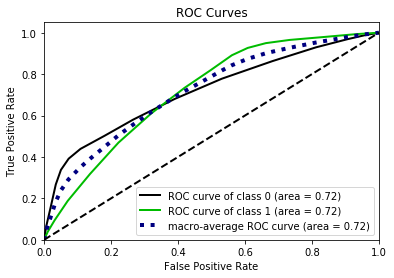

In [45]:
plot_roc(y_test, y_predicted, plot_micro=False)

In [46]:
pd.DataFrame(rs.cv_results_).to_csv("knn_results_2.csv", index=False, sep = "|")

/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/usuario/anaconda3/lib/py

### SVM

In [129]:
from sklearn.svm import SVC

In [130]:
svm_class = SVC()

In [139]:
pipeline = make_pipeline(fe_union, ss, pca, resampling_step, f_selection_step,svm_class)

In [140]:
from  sklearn.utils.random import sample_without_replacement

In [146]:
sample_idx = sample_without_replacement(X_train.shape[0], 10000)

In [147]:
X_train_svm = X_train.iloc[sample_idx,:]
y_train_svm = y_train.iloc[sample_idx]

In [148]:
params = {"featureunion__neigh_pipeline__encoder":[OneHotEncoder(categories=[neigh_top10],sparse = False,handle_unknown="ignore"),
                                                     OneHotEncoder(categories=[neigh_top20],sparse = False,handle_unknown="ignore"),
                                                     OneHotEncoder(categories=[neigh_top30],sparse = False,handle_unknown="ignore"),
                                                  OneHotEncoder(sparse = False,handle_unknown="ignore")], 
          "pca":[None],
         "smote": [None,RandomUnderSampler()], 
          "selectpercentile__percentile":[30, 20, 10],
         "svc__C":[0.5,0.7,0.9,1],
         "svc__kernel":['poly', 'rbf', 'sigmoid'],
         "svc__probability":[True]}

In [157]:
my_cv = TimeSeriesSplit(n_splits=2).split(X_train_svm)

In [158]:
rs = RandomizedSearchCV(estimator = pipeline, param_distributions=params,cv=my_cv, n_jobs=3, n_iter=20, scoring="roc_auc")

In [159]:
rs.fit(X_train_svm, y_train_svm)

/home/usuario/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if memory.cachedir is None:
/home/usuario/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if memory.cachedir is None:
/home/usuario/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if memory.cachedir is None:
/home/usuario/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning: The 'cachedir' attribute has been d

RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fd582ace570>,
          error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=None,
       transformer_list=[('neigh_pipeline', Pipeline(memory=None,
     steps=[('select', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function select_column_1 at 0x7fd5a6c8d048>,
          inv_kw_args=None, inverse_fun...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
          fit_params=None, iid='warn', n_iter=20, n_jobs=3,
          param_distributions={'featureunion__neigh_pipeline__encoder': [OneHotEncoder(categorical_features=None,
       categories=[array([ 4,  6,  8, 24, 26, 32, 36, 39, 50, 68])],
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=False), OneHotEncoder(categorical_f...'svc__C': [0.5, 0.7, 0.9, 1], 'svc__kernel': ['po

In [160]:
rs.best_score_

0.7048082394973969

In [161]:
y_predicted = rs.predict_proba(X_test)

In [162]:
roc_auc_score(y_test, y_predicted[:,1])

0.6891657625996719

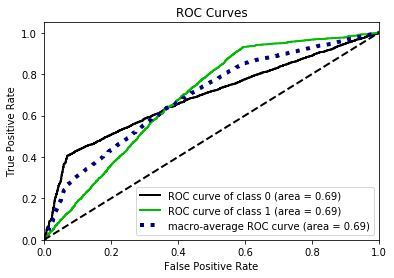

In [163]:
plot_roc(y_test, y_predicted, plot_micro=False)

In [164]:
pd.DataFrame(rs.cv_results_).to_csv("svm_results.csv", index=False, sep = "|")

/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/usuario/anaconda3/lib/py

In [ ]:
### NaiveBayes

In [64]:
from sklearn.naive_bayes import GaussianNB

In [65]:
nb = GaussianNB()

In [66]:
pipeline = make_pipeline(fe_union, pca, resampling_step, f_selection_step,nb)

In [67]:
params = {"featureunion__neigh_pipeline__encoder":[OneHotEncoder(categories=[neigh_top10],sparse = False,handle_unknown="ignore"),
                                                     OneHotEncoder(categories=[neigh_top20],sparse = False,handle_unknown="ignore"),
                                                     OneHotEncoder(categories=[neigh_top30],sparse = False,handle_unknown="ignore"),
                                                  OneHotEncoder(sparse = False,handle_unknown="ignore")], 
          "pca":[None, PCA()],
         "smote": [None,RandomUnderSampler(), SMOTE()], 
          "selectpercentile__percentile":[100,90,80,70]}
         

In [68]:
my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

In [69]:
rs = RandomizedSearchCV(estimator = pipeline, param_distributions=params,cv=my_cv, n_jobs=3, n_iter=20, scoring="roc_auc")

In [70]:
rs.fit(X_train, y_train)
rs.best_score_

/home/usuario/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if memory.cachedir is None:


0.6528996138371886

In [71]:
y_predicted = rs.predict_proba(X_test)
roc_auc_score(y_test, y_predicted[:,1])

0.6911629586415446

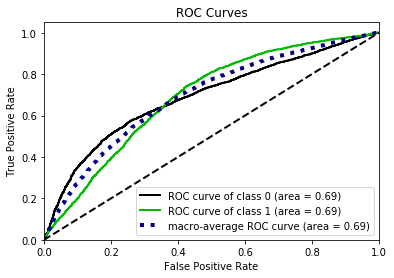

In [73]:
plot_roc(y_test, y_predicted, plot_micro=False)

In [72]:
pd.DataFrame(rs.cv_results_).to_csv("nb_results.csv", index=False, sep = "|")

/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/usuario/anaconda3/lib/py

### Logistic regression pipeline

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
logistic = LogisticRegression()

In [39]:
pipeline = make_pipeline(fe_union, pca, resampling_step, f_selection_step,logistic)

In [40]:
params = {"featureunion__neigh_pipeline__encoder":[OneHotEncoder(categories=[neigh_top10],sparse = False,handle_unknown="ignore"),
                                                     OneHotEncoder(categories=[neigh_top20],sparse = False,handle_unknown="ignore"),
                                                     OneHotEncoder(categories=[neigh_top30],sparse = False,handle_unknown="ignore"),
                                                  OneHotEncoder(sparse = False,handle_unknown="ignore")], 
          "pca":[None, PCA()],
         "smote": [None,RandomUnderSampler(), SMOTE()], 
          "selectpercentile__percentile":[100,90,80,70],
         "logisticregression__C":[1,2,0.9,0.7,0.5,3.4]}
         

In [41]:
my_cv = TimeSeriesSplit(n_splits=3).split(X_train)

In [42]:
rs = RandomizedSearchCV(estimator = pipeline, param_distributions=params,cv=my_cv, n_jobs=3, n_iter=20, scoring="roc_auc")

In [43]:
rs.fit(X_train, y_train)
rs.best_score_

/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [20 56 57] are constant.
  UserWarning)
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6527693964589576

In [44]:
y_predicted = rs.predict_proba(X_test)
roc_auc_score(y_test, y_predicted[:,1])

0.70795685165987

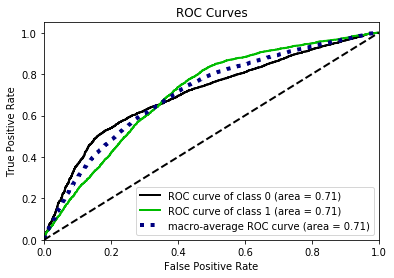

In [47]:
plot_roc(y_test, y_predicted, plot_micro=False)

In [48]:
pd.DataFrame(rs.cv_results_).to_csv("logistic_results.csv", index=False, sep = "|")

/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/usuario/anaconda3/lib/

### RandomForest Pipeline

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
rf = RandomForestClassifier()

In [57]:
import scipy.stats as st
one_to_left = st.beta(10, 1)

In [58]:
pipeline = make_pipeline(fe_union, pca, resampling_step, f_selection_step,rf)

In [59]:
pipeline.steps

[('featureunion', FeatureUnion(n_jobs=None,
         transformer_list=[('neigh_pipeline', Pipeline(memory=None,
       steps=[('select', FunctionTransformer(accept_sparse=False, check_inverse=True,
            func=<function select_column_1 at 0x7f4f57d0ff28>,
            inv_kw_args=None, inverse_func=None, kw_args=None,
            pass_y='deprecated', vali...v_kw_args=None, inverse_func=None, kw_args=None,
            pass_y='deprecated', validate=False))]))],
         transformer_weights=None)),
 ('pca',
  PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)),
 ('smote',
  SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
     out_step=0.5, random_state=None, ratio='auto', svm_estimator=None)),
 ('selectpercentile', SelectPercentile(percentile=10,
           score_func=<function f_classif at 0x7f4f5431b730>)),
 ('randomforestclassifier',
  RandomForestClassifier(bootstrap=True, class_w

In [60]:
params = {"featureunion__neigh_pipeline__encoder":[OneHotEncoder(categories=[neigh_top10], sparse=False, handle_unknown="ignore"),
                                                     OneHotEncoder(categories=[neigh_top20],sparse=False, handle_unknown="ignore"),
                                                     OneHotEncoder(categories=[neigh_top30],sparse=False, handle_unknown="ignore"),
                                                  OneHotEncoder(handle_unknown="ignore",sparse=False)],
          "pca":[None, PCA()],
         "smote": [None,RandomUnderSampler(), SMOTE()], 
          "selectpercentile__percentile":[100,90,80,70],
             "randomforestclassifier__n_estimators": [50,100,150,200,250], # Number of boosted trees to fit.
    "randomforestclassifier__max_depth": st.randint(3, 25),     # Maximum tree depth for base learners.
    "randomforestclassifier__min_impurity_decrease": [0.0,0.1,0.15,0.2,0.25,0.3]}

In [61]:
my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

In [62]:
rs = RandomizedSearchCV(estimator = pipeline, param_distributions=params,cv=my_cv, n_jobs=3, n_iter=40, scoring="roc_auc")

In [63]:
rs.fit(X_train, y_train)

/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [20 56 57] are constant.
  UserWarning)
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f4f3d03d1a8>,
          error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=None,
       transformer_list=[('neigh_pipeline', Pipeline(memory=None,
     steps=[('select', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function select_column_1 at 0x7f4f57d0ff28>,
          inv_kw_args=None, inverse_fun...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
          fit_params=None, iid='warn', n_iter=40, n_jobs=3,
          param_distributions={'featureunion__neigh_pipeline__encoder': [OneHotEncoder(categorical_features=None,
       categories=[array([ 4,  6,  8, 24, 26, 32, 36, 39, 50, 68])],
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=False), OneHotEncoder(categorical_f... 0x7f4f3d051080>, 'randomforestclassifier__min_im

In [64]:
rs.best_score_

0.7486621697043783

In [65]:
y_predicted = rs.predict_proba(X_test)
roc_auc_score(y_test, y_predicted[:,1])

0.7405452914570377

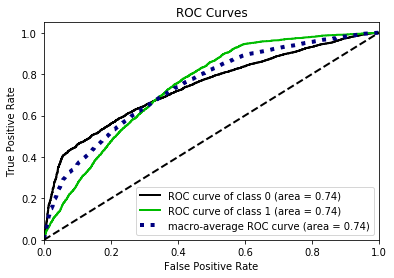

In [66]:
plot_roc(y_test, y_predicted, plot_micro=False)

In [67]:
pd.DataFrame(rs.cv_results_).to_csv("random_f_results.csv", index=False, sep = "|")

/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/usuario/anaconda3/lib/py

### LightGBM pipeline

In [74]:
from lightgbm.sklearn import LGBMClassifier

In [76]:
model = LGBMClassifier()

In [77]:
pipeline = make_pipeline(fe_union, pca, resampling_step, f_selection_step,model)

In [79]:
params = {"featureunion__neigh_pipeline__encoder":[OneHotEncoder(categories=[neigh_top10], sparse=False, handle_unknown="ignore"),
                                                     OneHotEncoder(categories=[neigh_top20],sparse=False, handle_unknown="ignore"),
                                                     OneHotEncoder(categories=[neigh_top30],sparse=False, handle_unknown="ignore"),
                                                  OneHotEncoder(handle_unknown="ignore",sparse=False)],
          "pca":[None, PCA()],
         "smote": [None,RandomUnderSampler(), SMOTE()], 
          "selectpercentile__percentile":[100,90,80,70],
             "lgbmclassifier__n_estimators": [50,100,150,200,250], # Number of boosted trees to fit.
    "lgbmclassifier__max_depth": st.randint(3, 12),     # Maximum tree depth for base learners.
    "lgbmclassifier__learning_rate": st.uniform(0.05, 0.4), #     Boosting learning rate (xgb’s “eta”)
    "lgbmclassifier__colsample_bytree": one_to_left, #     Subsampl/e ratio of columns when constructing each tree.
    "lgbmclassifier__subsample": one_to_left,     # Subsample ratio of the training instance.
    "lgbmclassifier__gamma": st.uniform(0, 10), #     Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'lgbmclassifier__reg_alpha': st.uniform(0.05,10),   # L1 regularization term on weights
    "lgbmclassifier__min_child_weight": st.uniform(1,20) #    Minimum sum of instance weight(hessian) needed in a child.
         }

In [80]:
my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

In [81]:
rs = RandomizedSearchCV(estimator = pipeline, param_distributions=params,cv=my_cv, n_jobs=3, n_iter=40, scoring="roc_auc")

In [82]:
rs.fit(X_train, y_train)

/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/usuario/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if memory.cachedir is None:
/home/usuario/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if memory.cachedir is None:
/home/usuario/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning: The 'cachedir' at

RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fd2e0a3de60>,
          error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=None,
       transformer_list=[('neigh_pipeline', Pipeline(memory=None,
     steps=[('select', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function select_column_1 at 0x7fd2f0a93ea0>,
          inv_kw_args=None, inverse_fun...0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1))]),
          fit_params=None, iid='warn', n_iter=40, n_jobs=3,
          param_distributions={'featureunion__neigh_pipeline__encoder': [OneHotEncoder(categorical_features=None,
       categories=[array([ 4,  6,  8, 24, 26, 32, 36, 39, 50, 68])],
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=False), OneHotEncoder(categorical_f...assifier__min_child_weight': <scipy.stats._distn_

In [83]:
rs.best_score_ # Best score in CV

0.7511577693290333

In [84]:
y_predicted = rs.predict_proba(X_test)

In [85]:
roc_auc_score(y_test, y_predicted[:,1])

0.7420955637866895

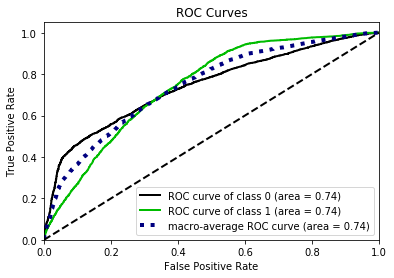

In [86]:
plot_roc(y_test, y_predicted, plot_micro=False)

In [87]:
pd.DataFrame(rs.cv_results_).to_csv("lgbm_results.csv", index=False, sep = "|")

/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/usuario/anaconda3/lib/py

### CatBoost

In [68]:
from catboost import CatBoostClassifier

In [69]:
cboost = CatBoostClassifier()

In [70]:
pipeline = make_pipeline(fe_union, pca, resampling_step, f_selection_step,cboost)

In [77]:
pipeline

Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=None,
       transformer_list=[('neigh_pipeline', Pipeline(memory=None,
     steps=[('select', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function select_column_1 at 0x7f4f57d0ff28>,
          inv_kw_args=None, inverse_fun...f4f5431b730>)), ('catboostclassifier', <catboost.core.CatBoostClassifier object at 0x7f4f3cfd30b8>)])

In [72]:
params = {"featureunion__neigh_pipeline__encoder":[OneHotEncoder(categories=[neigh_top10], sparse=False, handle_unknown="ignore"),
                                                     OneHotEncoder(categories=[neigh_top20],sparse=False, handle_unknown="ignore"),
                                                     OneHotEncoder(categories=[neigh_top30],sparse=False, handle_unknown="ignore"),
                                                  OneHotEncoder(handle_unknown="ignore",sparse=False)],
          "pca":[None, PCA()],
         "smote": [None,RandomUnderSampler(), SMOTE()], 
          "selectpercentile__percentile":[100,90,80,70],
             "catboostclassifier__iterations": [50,100,150,200,250], # Number of boosted trees to fit.
    "catboostclassifier__depth": st.randint(3, 12),     # Maximum tree depth for base learners.
    "catboostclassifier__learning_rate": st.uniform(0.05, 0.4), #     Boosting learning rate (xgb’s “eta”)
    "catboostclassifier__rsm": [0.2,0.3,0.4,0.5],
    'catboostclassifier__l2_leaf_reg': st.uniform(0.05,10)
         }

In [119]:
my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

In [120]:
rs = RandomizedSearchCV(estimator = pipeline, param_distributions=params,cv=my_cv, n_jobs=3, n_iter=40, scoring="roc_auc")

In [121]:
rs.fit(X_train, y_train)

/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [20 56 57] are constant.
  UserWarning)
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


0:	learn: 0.6208791	total: 75.8ms	remaining: 18.9s
1:	learn: 0.5716561	total: 104ms	remaining: 12.8s
2:	learn: 0.5362457	total: 130ms	remaining: 10.7s
3:	learn: 0.5110149	total: 154ms	remaining: 9.48s
4:	learn: 0.4970593	total: 175ms	remaining: 8.59s
5:	learn: 0.4854138	total: 197ms	remaining: 8.01s
6:	learn: 0.4753974	total: 220ms	remaining: 7.65s
7:	learn: 0.4680559	total: 242ms	remaining: 7.31s
8:	learn: 0.4614730	total: 263ms	remaining: 7.03s
9:	learn: 0.4566036	total: 289ms	remaining: 6.95s
10:	learn: 0.4545623	total: 315ms	remaining: 6.83s
11:	learn: 0.4525824	total: 338ms	remaining: 6.7s
12:	learn: 0.4512186	total: 360ms	remaining: 6.55s
13:	learn: 0.4499143	total: 382ms	remaining: 6.43s
14:	learn: 0.4490510	total: 403ms	remaining: 6.31s
15:	learn: 0.4472450	total: 425ms	remaining: 6.21s
16:	learn: 0.4463550	total: 445ms	remaining: 6.11s
17:	learn: 0.4450166	total: 467ms	remaining: 6.02s
18:	learn: 0.4438888	total: 491ms	remaining: 5.97s
19:	learn: 0.4435777	total: 520ms	remaini

161:	learn: 0.4330599	total: 3.59s	remaining: 1.95s
162:	learn: 0.4330407	total: 3.61s	remaining: 1.93s
163:	learn: 0.4329872	total: 3.63s	remaining: 1.9s
164:	learn: 0.4329415	total: 3.65s	remaining: 1.88s
165:	learn: 0.4328984	total: 3.67s	remaining: 1.86s
166:	learn: 0.4328823	total: 3.69s	remaining: 1.83s
167:	learn: 0.4328716	total: 3.71s	remaining: 1.81s
168:	learn: 0.4328517	total: 3.73s	remaining: 1.79s
169:	learn: 0.4328272	total: 3.75s	remaining: 1.77s
170:	learn: 0.4327953	total: 3.77s	remaining: 1.74s
171:	learn: 0.4327641	total: 3.8s	remaining: 1.72s
172:	learn: 0.4327481	total: 3.82s	remaining: 1.7s
173:	learn: 0.4327142	total: 3.84s	remaining: 1.68s
174:	learn: 0.4326713	total: 3.86s	remaining: 1.65s
175:	learn: 0.4326554	total: 3.88s	remaining: 1.63s
176:	learn: 0.4326322	total: 3.9s	remaining: 1.61s
177:	learn: 0.4326125	total: 3.92s	remaining: 1.59s
178:	learn: 0.4325862	total: 3.94s	remaining: 1.56s
179:	learn: 0.4325658	total: 3.96s	remaining: 1.54s
180:	learn: 0.43

RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fd5941d5728>,
          error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=None,
       transformer_list=[('neigh_pipeline', Pipeline(memory=None,
     steps=[('select', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function select_column_1 at 0x7fd5a6c8d048>,
          inv_kw_args=None, inverse_fun...fd5a3299730>)), ('catboostclassifier', <catboost.core.CatBoostClassifier object at 0x7fd59429c5f8>)]),
          fit_params=None, iid='warn', n_iter=40, n_jobs=3,
          param_distributions={'featureunion__neigh_pipeline__encoder': [OneHotEncoder(categorical_features=None,
       categories=[array([ 4,  6,  8, 24, 26, 32, 36, 39, 50, 68])],
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=False), OneHotEncoder(categorical_f...ostclassifier__l2_leaf_reg': <scipy.stats._distn_

In [122]:
rs.best_score_ # Best score in CV

0.7502751839768236

In [123]:
y_predicted = rs.predict_proba(X_test)

In [124]:
roc_auc_score(y_test, y_predicted[:,1])

0.7432791177824467

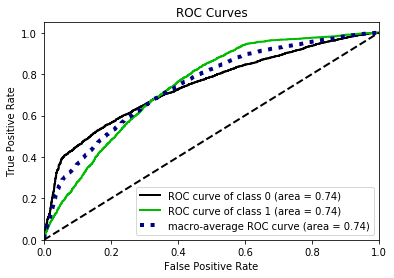

In [127]:
plot_roc(y_test, y_predicted, plot_micro=False)

In [128]:
pd.DataFrame(rs.cv_results_).to_csv("catboost_results.csv", index=False, sep = "|")

/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/usuario/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/usuario/anaconda3/lib/py

In [108]:
from scikitplot.estimators import plot_learning_curve

0:	learn: 0.6770499	total: 11.9ms	remaining: 2.95s
1:	learn: 0.6592913	total: 15.2ms	remaining: 1.88s
2:	learn: 0.6435040	total: 20.1ms	remaining: 1.66s
3:	learn: 0.6318321	total: 23.5ms	remaining: 1.45s
4:	learn: 0.6236622	total: 26.9ms	remaining: 1.32s
5:	learn: 0.6194195	total: 29.7ms	remaining: 1.21s
6:	learn: 0.6136502	total: 32.8ms	remaining: 1.14s
7:	learn: 0.6104156	total: 35.6ms	remaining: 1.08s
8:	learn: 0.6060321	total: 38.7ms	remaining: 1.04s
9:	learn: 0.6039753	total: 41.6ms	remaining: 998ms
10:	learn: 0.6006495	total: 44.8ms	remaining: 973ms
11:	learn: 0.5994851	total: 47.3ms	remaining: 937ms
12:	learn: 0.5969755	total: 50ms	remaining: 911ms
13:	learn: 0.5952109	total: 53.2ms	remaining: 897ms
14:	learn: 0.5940877	total: 56.4ms	remaining: 884ms
15:	learn: 0.5925074	total: 59.3ms	remaining: 868ms
16:	learn: 0.5919695	total: 62.2ms	remaining: 853ms
17:	learn: 0.5905276	total: 65.5ms	remaining: 844ms
18:	learn: 0.5904318	total: 68.1ms	remaining: 828ms
19:	learn: 0.5899182	tot

168:	learn: 0.5377686	total: 607ms	remaining: 291ms
169:	learn: 0.5375071	total: 610ms	remaining: 287ms
170:	learn: 0.5372888	total: 613ms	remaining: 283ms
171:	learn: 0.5372440	total: 616ms	remaining: 279ms
172:	learn: 0.5372197	total: 619ms	remaining: 275ms
173:	learn: 0.5371072	total: 624ms	remaining: 272ms
174:	learn: 0.5370234	total: 634ms	remaining: 272ms
175:	learn: 0.5368779	total: 638ms	remaining: 268ms
176:	learn: 0.5367165	total: 641ms	remaining: 264ms
177:	learn: 0.5365414	total: 644ms	remaining: 261ms
178:	learn: 0.5359902	total: 648ms	remaining: 257ms
179:	learn: 0.5358829	total: 650ms	remaining: 253ms
180:	learn: 0.5357437	total: 654ms	remaining: 249ms
181:	learn: 0.5356780	total: 657ms	remaining: 245ms
182:	learn: 0.5355388	total: 660ms	remaining: 242ms
183:	learn: 0.5354164	total: 663ms	remaining: 238ms
184:	learn: 0.5351180	total: 668ms	remaining: 235ms
185:	learn: 0.5348614	total: 672ms	remaining: 231ms
186:	learn: 0.5348488	total: 675ms	remaining: 227ms
187:	learn: 

105:	learn: 0.5841421	total: 603ms	remaining: 819ms
106:	learn: 0.5840980	total: 611ms	remaining: 816ms
107:	learn: 0.5839459	total: 618ms	remaining: 812ms
108:	learn: 0.5838314	total: 627ms	remaining: 811ms
109:	learn: 0.5838213	total: 632ms	remaining: 804ms
110:	learn: 0.5835903	total: 637ms	remaining: 798ms
111:	learn: 0.5833210	total: 643ms	remaining: 792ms
112:	learn: 0.5832400	total: 648ms	remaining: 786ms
113:	learn: 0.5831541	total: 654ms	remaining: 780ms
114:	learn: 0.5830578	total: 659ms	remaining: 773ms
115:	learn: 0.5828405	total: 664ms	remaining: 767ms
116:	learn: 0.5827013	total: 669ms	remaining: 761ms
117:	learn: 0.5826501	total: 675ms	remaining: 755ms
118:	learn: 0.5826422	total: 679ms	remaining: 748ms
119:	learn: 0.5825045	total: 684ms	remaining: 741ms
120:	learn: 0.5821773	total: 690ms	remaining: 735ms
121:	learn: 0.5819917	total: 696ms	remaining: 731ms
122:	learn: 0.5818648	total: 702ms	remaining: 724ms
123:	learn: 0.5816193	total: 707ms	remaining: 718ms
124:	learn: 

25:	learn: 0.6079258	total: 218ms	remaining: 1.88s
26:	learn: 0.6075028	total: 230ms	remaining: 1.9s
27:	learn: 0.6072368	total: 237ms	remaining: 1.88s
28:	learn: 0.6070967	total: 247ms	remaining: 1.88s
29:	learn: 0.6068951	total: 255ms	remaining: 1.87s
30:	learn: 0.6064877	total: 263ms	remaining: 1.86s
31:	learn: 0.6059461	total: 271ms	remaining: 1.85s
32:	learn: 0.6055859	total: 280ms	remaining: 1.84s
33:	learn: 0.6054738	total: 288ms	remaining: 1.83s
34:	learn: 0.6053280	total: 296ms	remaining: 1.82s
35:	learn: 0.6052103	total: 304ms	remaining: 1.8s
36:	learn: 0.6052098	total: 310ms	remaining: 1.78s
37:	learn: 0.6049869	total: 319ms	remaining: 1.78s
38:	learn: 0.6048825	total: 327ms	remaining: 1.77s
39:	learn: 0.6048636	total: 336ms	remaining: 1.76s
40:	learn: 0.6048128	total: 348ms	remaining: 1.77s
41:	learn: 0.6046532	total: 355ms	remaining: 1.76s
42:	learn: 0.6043428	total: 363ms	remaining: 1.75s
43:	learn: 0.6041141	total: 371ms	remaining: 1.74s
44:	learn: 0.6039344	total: 379ms

197:	learn: 0.5860753	total: 1.64s	remaining: 431ms
198:	learn: 0.5860191	total: 1.66s	remaining: 424ms
199:	learn: 0.5858921	total: 1.66s	remaining: 416ms
200:	learn: 0.5858421	total: 1.68s	remaining: 408ms
201:	learn: 0.5857984	total: 1.68s	remaining: 400ms
202:	learn: 0.5857177	total: 1.69s	remaining: 392ms
203:	learn: 0.5855692	total: 1.7s	remaining: 383ms
204:	learn: 0.5854503	total: 1.71s	remaining: 375ms
205:	learn: 0.5854151	total: 1.72s	remaining: 366ms
206:	learn: 0.5854025	total: 1.72s	remaining: 358ms
207:	learn: 0.5852585	total: 1.73s	remaining: 349ms
208:	learn: 0.5851331	total: 1.74s	remaining: 341ms
209:	learn: 0.5850467	total: 1.75s	remaining: 333ms
210:	learn: 0.5849323	total: 1.75s	remaining: 324ms
211:	learn: 0.5849224	total: 1.76s	remaining: 316ms
212:	learn: 0.5849029	total: 1.77s	remaining: 308ms
213:	learn: 0.5848483	total: 1.78s	remaining: 299ms
214:	learn: 0.5848376	total: 1.78s	remaining: 291ms
215:	learn: 0.5846694	total: 1.8s	remaining: 283ms
216:	learn: 0.

110:	learn: 0.5931491	total: 1.03s	remaining: 1.29s
111:	learn: 0.5931036	total: 1.04s	remaining: 1.28s
112:	learn: 0.5930702	total: 1.05s	remaining: 1.27s
113:	learn: 0.5929621	total: 1.06s	remaining: 1.26s
114:	learn: 0.5929051	total: 1.07s	remaining: 1.26s
115:	learn: 0.5927990	total: 1.08s	remaining: 1.25s
116:	learn: 0.5926267	total: 1.09s	remaining: 1.24s
117:	learn: 0.5925128	total: 1.1s	remaining: 1.23s
118:	learn: 0.5925031	total: 1.11s	remaining: 1.22s
119:	learn: 0.5923427	total: 1.12s	remaining: 1.21s
120:	learn: 0.5923239	total: 1.13s	remaining: 1.21s
121:	learn: 0.5922875	total: 1.14s	remaining: 1.2s
122:	learn: 0.5921467	total: 1.15s	remaining: 1.19s
123:	learn: 0.5920488	total: 1.16s	remaining: 1.18s
124:	learn: 0.5919709	total: 1.17s	remaining: 1.17s
125:	learn: 0.5917653	total: 1.18s	remaining: 1.16s
126:	learn: 0.5916507	total: 1.18s	remaining: 1.15s
127:	learn: 0.5916129	total: 1.19s	remaining: 1.14s
128:	learn: 0.5915288	total: 1.2s	remaining: 1.13s
129:	learn: 0.5

29:	learn: 0.5666080	total: 429ms	remaining: 3.14s
30:	learn: 0.5662634	total: 450ms	remaining: 3.18s
31:	learn: 0.5660075	total: 465ms	remaining: 3.17s
32:	learn: 0.5657845	total: 491ms	remaining: 3.23s
33:	learn: 0.5655129	total: 507ms	remaining: 3.22s
34:	learn: 0.5654781	total: 524ms	remaining: 3.22s
35:	learn: 0.5653777	total: 540ms	remaining: 3.21s
36:	learn: 0.5651466	total: 556ms	remaining: 3.2s
37:	learn: 0.5647565	total: 573ms	remaining: 3.2s
38:	learn: 0.5647564	total: 586ms	remaining: 3.17s
39:	learn: 0.5645738	total: 600ms	remaining: 3.15s
40:	learn: 0.5644566	total: 614ms	remaining: 3.13s
41:	learn: 0.5641844	total: 628ms	remaining: 3.11s
42:	learn: 0.5641734	total: 644ms	remaining: 3.1s
43:	learn: 0.5640380	total: 657ms	remaining: 3.07s
44:	learn: 0.5638371	total: 670ms	remaining: 3.05s
45:	learn: 0.5636642	total: 683ms	remaining: 3.03s
46:	learn: 0.5635508	total: 697ms	remaining: 3.01s
47:	learn: 0.5634504	total: 710ms	remaining: 2.99s
48:	learn: 0.5632556	total: 723ms	

195:	learn: 0.5518235	total: 3.17s	remaining: 875ms
196:	learn: 0.5517786	total: 3.19s	remaining: 858ms
197:	learn: 0.5517428	total: 3.2s	remaining: 841ms
198:	learn: 0.5516923	total: 3.21s	remaining: 824ms
199:	learn: 0.5516138	total: 3.23s	remaining: 807ms
200:	learn: 0.5516073	total: 3.24s	remaining: 790ms
201:	learn: 0.5516048	total: 3.25s	remaining: 773ms
202:	learn: 0.5515835	total: 3.26s	remaining: 755ms
203:	learn: 0.5514836	total: 3.27s	remaining: 739ms
204:	learn: 0.5514453	total: 3.29s	remaining: 722ms
205:	learn: 0.5514122	total: 3.3s	remaining: 705ms
206:	learn: 0.5513690	total: 3.31s	remaining: 688ms
207:	learn: 0.5512991	total: 3.33s	remaining: 672ms
208:	learn: 0.5512389	total: 3.34s	remaining: 655ms
209:	learn: 0.5511075	total: 3.35s	remaining: 638ms
210:	learn: 0.5510670	total: 3.36s	remaining: 622ms
211:	learn: 0.5509929	total: 3.38s	remaining: 606ms
212:	learn: 0.5509615	total: 3.4s	remaining: 590ms
213:	learn: 0.5508910	total: 3.41s	remaining: 573ms
214:	learn: 0.5

112:	learn: 0.5468824	total: 396ms	remaining: 481ms
113:	learn: 0.5468059	total: 400ms	remaining: 478ms
114:	learn: 0.5466610	total: 404ms	remaining: 475ms
115:	learn: 0.5463659	total: 409ms	remaining: 473ms
116:	learn: 0.5461046	total: 413ms	remaining: 470ms
117:	learn: 0.5455772	total: 417ms	remaining: 466ms
118:	learn: 0.5453093	total: 420ms	remaining: 462ms
119:	learn: 0.5450572	total: 423ms	remaining: 459ms
120:	learn: 0.5449473	total: 427ms	remaining: 455ms
121:	learn: 0.5445100	total: 430ms	remaining: 451ms
122:	learn: 0.5445073	total: 433ms	remaining: 447ms
123:	learn: 0.5439511	total: 436ms	remaining: 443ms
124:	learn: 0.5436215	total: 439ms	remaining: 439ms
125:	learn: 0.5433265	total: 443ms	remaining: 436ms
126:	learn: 0.5428940	total: 446ms	remaining: 432ms
127:	learn: 0.5427575	total: 449ms	remaining: 428ms
128:	learn: 0.5424792	total: 453ms	remaining: 425ms
129:	learn: 0.5424162	total: 456ms	remaining: 421ms
130:	learn: 0.5419703	total: 460ms	remaining: 417ms
131:	learn: 

32:	learn: 0.5984442	total: 208ms	remaining: 1.37s
33:	learn: 0.5982017	total: 219ms	remaining: 1.39s
34:	learn: 0.5978901	total: 224ms	remaining: 1.38s
35:	learn: 0.5975904	total: 230ms	remaining: 1.37s
36:	learn: 0.5974418	total: 236ms	remaining: 1.36s
37:	learn: 0.5968259	total: 242ms	remaining: 1.35s
38:	learn: 0.5966516	total: 248ms	remaining: 1.34s
39:	learn: 0.5965212	total: 254ms	remaining: 1.33s
40:	learn: 0.5957957	total: 260ms	remaining: 1.32s
41:	learn: 0.5956884	total: 265ms	remaining: 1.31s
42:	learn: 0.5954229	total: 271ms	remaining: 1.3s
43:	learn: 0.5952871	total: 277ms	remaining: 1.3s
44:	learn: 0.5952104	total: 282ms	remaining: 1.28s
45:	learn: 0.5949596	total: 288ms	remaining: 1.28s
46:	learn: 0.5948000	total: 294ms	remaining: 1.27s
47:	learn: 0.5945366	total: 300ms	remaining: 1.26s
48:	learn: 0.5945366	total: 304ms	remaining: 1.25s
49:	learn: 0.5942599	total: 310ms	remaining: 1.24s
50:	learn: 0.5940180	total: 316ms	remaining: 1.23s
51:	learn: 0.5939029	total: 322ms

197:	learn: 0.5741499	total: 1.22s	remaining: 320ms
198:	learn: 0.5739831	total: 1.23s	remaining: 315ms
199:	learn: 0.5739186	total: 1.24s	remaining: 309ms
200:	learn: 0.5737797	total: 1.24s	remaining: 303ms
201:	learn: 0.5736496	total: 1.25s	remaining: 296ms
202:	learn: 0.5735356	total: 1.25s	remaining: 290ms
203:	learn: 0.5735198	total: 1.26s	remaining: 284ms
204:	learn: 0.5734670	total: 1.26s	remaining: 278ms
205:	learn: 0.5732985	total: 1.27s	remaining: 272ms
206:	learn: 0.5732203	total: 1.28s	remaining: 265ms
207:	learn: 0.5731013	total: 1.28s	remaining: 259ms
208:	learn: 0.5730474	total: 1.29s	remaining: 253ms
209:	learn: 0.5728764	total: 1.3s	remaining: 247ms
210:	learn: 0.5726958	total: 1.3s	remaining: 241ms
211:	learn: 0.5725934	total: 1.31s	remaining: 235ms
212:	learn: 0.5724246	total: 1.31s	remaining: 229ms
213:	learn: 0.5723145	total: 1.32s	remaining: 222ms
214:	learn: 0.5721935	total: 1.33s	remaining: 216ms
215:	learn: 0.5721350	total: 1.33s	remaining: 210ms
216:	learn: 0.

113:	learn: 0.5961343	total: 1.24s	remaining: 1.48s
114:	learn: 0.5960869	total: 1.26s	remaining: 1.48s
115:	learn: 0.5960732	total: 1.27s	remaining: 1.47s
116:	learn: 0.5959346	total: 1.28s	remaining: 1.46s
117:	learn: 0.5957685	total: 1.3s	remaining: 1.45s
118:	learn: 0.5956846	total: 1.31s	remaining: 1.44s
119:	learn: 0.5954569	total: 1.32s	remaining: 1.43s
120:	learn: 0.5953702	total: 1.33s	remaining: 1.42s
121:	learn: 0.5953147	total: 1.34s	remaining: 1.41s
122:	learn: 0.5953112	total: 1.35s	remaining: 1.4s
123:	learn: 0.5952071	total: 1.36s	remaining: 1.39s
124:	learn: 0.5951347	total: 1.38s	remaining: 1.38s
125:	learn: 0.5950935	total: 1.39s	remaining: 1.36s
126:	learn: 0.5949237	total: 1.4s	remaining: 1.35s
127:	learn: 0.5947742	total: 1.41s	remaining: 1.34s
128:	learn: 0.5947737	total: 1.42s	remaining: 1.33s
129:	learn: 0.5946493	total: 1.43s	remaining: 1.32s
130:	learn: 0.5946429	total: 1.44s	remaining: 1.31s
131:	learn: 0.5945859	total: 1.46s	remaining: 1.3s
132:	learn: 0.59

33:	learn: 0.6031394	total: 422ms	remaining: 2.68s
34:	learn: 0.6029789	total: 440ms	remaining: 2.71s
35:	learn: 0.6029042	total: 458ms	remaining: 2.72s
36:	learn: 0.6027283	total: 471ms	remaining: 2.71s
37:	learn: 0.6026338	total: 482ms	remaining: 2.69s
38:	learn: 0.6024988	total: 500ms	remaining: 2.71s
39:	learn: 0.6023776	total: 512ms	remaining: 2.69s
40:	learn: 0.6023513	total: 523ms	remaining: 2.67s
41:	learn: 0.6022283	total: 536ms	remaining: 2.65s
42:	learn: 0.6022092	total: 547ms	remaining: 2.63s
43:	learn: 0.6021620	total: 563ms	remaining: 2.63s
44:	learn: 0.6019187	total: 575ms	remaining: 2.62s
45:	learn: 0.6017684	total: 588ms	remaining: 2.6s
46:	learn: 0.6015231	total: 600ms	remaining: 2.59s
47:	learn: 0.6014063	total: 613ms	remaining: 2.58s
48:	learn: 0.6011878	total: 629ms	remaining: 2.58s
49:	learn: 0.6010005	total: 643ms	remaining: 2.57s
50:	learn: 0.6008447	total: 655ms	remaining: 2.56s
51:	learn: 0.6005183	total: 667ms	remaining: 2.54s
52:	learn: 0.6004821	total: 678m

205:	learn: 0.5878358	total: 2.49s	remaining: 533ms
206:	learn: 0.5877931	total: 2.52s	remaining: 523ms
207:	learn: 0.5877146	total: 2.53s	remaining: 510ms
208:	learn: 0.5876569	total: 2.54s	remaining: 498ms
209:	learn: 0.5875454	total: 2.55s	remaining: 486ms
210:	learn: 0.5875142	total: 2.56s	remaining: 473ms
211:	learn: 0.5873886	total: 2.57s	remaining: 461ms
212:	learn: 0.5873866	total: 2.58s	remaining: 449ms
213:	learn: 0.5872968	total: 2.6s	remaining: 437ms
214:	learn: 0.5872514	total: 2.61s	remaining: 424ms
215:	learn: 0.5871989	total: 2.62s	remaining: 412ms
216:	learn: 0.5871606	total: 2.63s	remaining: 400ms
217:	learn: 0.5871488	total: 2.64s	remaining: 388ms
218:	learn: 0.5870886	total: 2.66s	remaining: 376ms
219:	learn: 0.5870492	total: 2.67s	remaining: 364ms
220:	learn: 0.5870053	total: 2.69s	remaining: 353ms
221:	learn: 0.5869584	total: 2.71s	remaining: 341ms
222:	learn: 0.5868929	total: 2.72s	remaining: 329ms
223:	learn: 0.5868444	total: 2.73s	remaining: 317ms
224:	learn: 0

122:	learn: 0.5557297	total: 1.89s	remaining: 1.95s
123:	learn: 0.5556292	total: 1.91s	remaining: 1.94s
124:	learn: 0.5555937	total: 1.92s	remaining: 1.92s
125:	learn: 0.5555284	total: 1.94s	remaining: 1.9s
126:	learn: 0.5554543	total: 1.95s	remaining: 1.89s
127:	learn: 0.5554166	total: 1.96s	remaining: 1.87s
128:	learn: 0.5552996	total: 1.98s	remaining: 1.85s
129:	learn: 0.5551473	total: 1.99s	remaining: 1.83s
130:	learn: 0.5551159	total: 2s	remaining: 1.82s
131:	learn: 0.5550550	total: 2.02s	remaining: 1.8s
132:	learn: 0.5550218	total: 2.03s	remaining: 1.78s
133:	learn: 0.5549981	total: 2.04s	remaining: 1.77s
134:	learn: 0.5548827	total: 2.06s	remaining: 1.75s
135:	learn: 0.5548162	total: 2.07s	remaining: 1.74s
136:	learn: 0.5547696	total: 2.08s	remaining: 1.72s
137:	learn: 0.5547204	total: 2.1s	remaining: 1.71s
138:	learn: 0.5547115	total: 2.12s	remaining: 1.69s
139:	learn: 0.5546792	total: 2.13s	remaining: 1.68s
140:	learn: 0.5546615	total: 2.15s	remaining: 1.66s
141:	learn: 0.5545

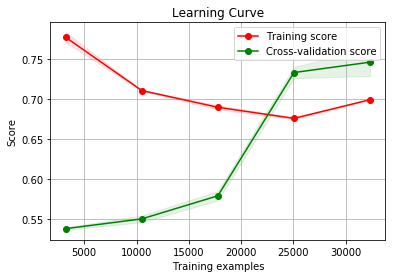

In [111]:
plot_learning_curve(cboost, X_train, y_train,cv = TimeSeriesSplit(n_splits=2).split(X_train), scoring="roc_auc")